# MRI Dementia Classification - Load Pre-Saved Models
This model is used for MRI classification of dementia with 4 known stages (Non-Demented, Mild Demented, Moderate Demented and Very Mild Demented). Severe onset dementia is known as Alzheimer's Disease which will not be covered in this analysis. All data sourced from https://www.kaggle.com/datasets/matthewhema/mri-dementia-augmentation-no-data-leak

In [1]:
# Import Dependencies and Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Load MRI Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("matthewhema/mri-dementia-augmentation-no-data-leak")

print("Path to dataset files:", path)

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/mattle/.cache/kagglehub/datasets/matthewhema/mri-dementia-augmentation-no-data-leak/versions/1


## Image Processing

Here we're leveraging a function called ImageDataGenerator() from the Tensor library to combine all of the operations of rescaling, setting our target size, batch size, etc to prep them into respective bins - Train, Test and Validation. 

In [3]:
# Resize all input images to 224x224
image_size = (224, 224)

# Number of images the model processes before updating weights
batch_size = 32

# Set local data paths
train_dir = path + '/Train/Train'
val_dir = path + '/Val/Val'
test_dir = path + '/Test/Test'

# Store ImageDataGenerator parameters in a dictionary
imageDataGenerator_params = {
    'rescale': 1./255,
}

In [ ]:
# Image Generators 

# Rescaling [0,1] for neural networks to process normalized values
train_datagen = ImageDataGenerator(imageDataGenerator_params)
val_datagen = ImageDataGenerator(imageDataGenerator_params)
test_datagen = ImageDataGenerator(imageDataGenerator_params)

# Create Generators for Train, Val and Test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 11350 images belonging to 4 classes.
Found 960 images belonging to 4 classes.
Found 960 images belonging to 4 classes.


## Load the Model and History files

In [5]:
# Load the model
model = load_model('saved_models/dementia_cnn_sequential_4_model_V2.keras')

In [6]:
# Load the pickle file into history
import pickle

with open('saved_models/dementia_cnn_sequential_4_history_V2.pkl', 'rb') as f:
    history_dict = pickle.load(f)

class History:
    def __init__(self, history):
        self.history = history

history = History(history_dict)

### Run the Model on Test data

In [7]:
%%time
# Evaluation on Test Set
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9768 - loss: 0.0672
Test Accuracy: 0.96
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step
CPU times: user 58 s, sys: 5.73 s, total: 1min 3s
Wall time: 12.6 s


### Analysis of Results

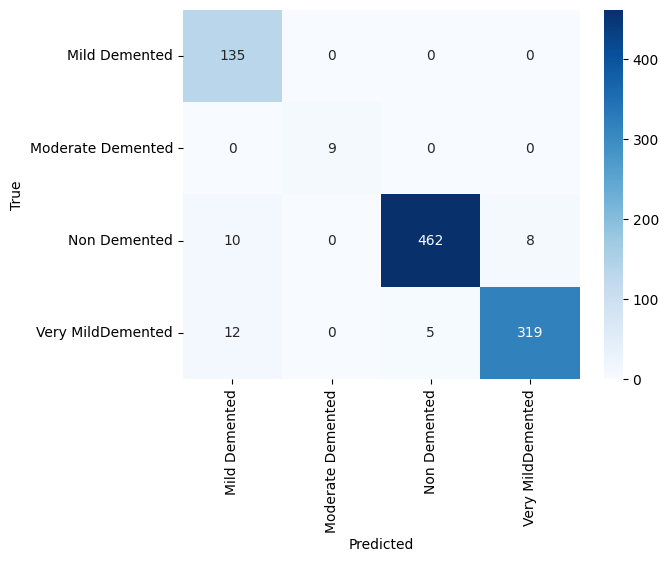

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       135
           1       1.00      1.00      1.00         9
           2       0.99      0.96      0.98       480
           3       0.98      0.95      0.96       336

    accuracy                           0.96       960
   macro avg       0.96      0.98      0.97       960
weighted avg       0.97      0.96      0.96       960



In [8]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred_classes))

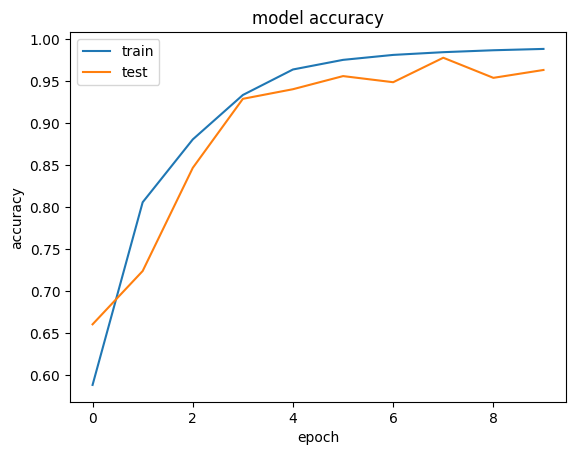

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

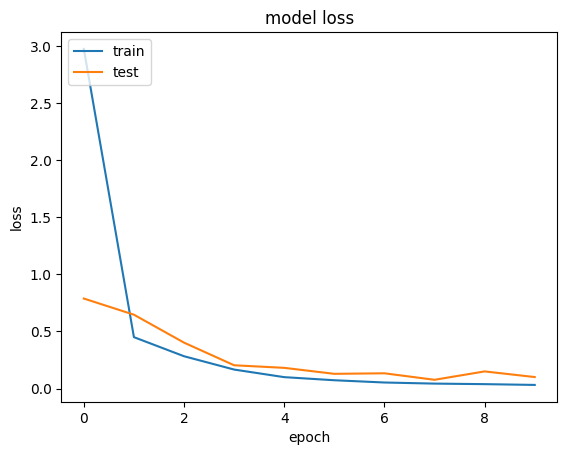

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()